## Populating haloes with galaxies

In [2]:
# science imports
import numpy as np
import py21cmfast as p21c
from astropy import units as u
from astropy.constants import c
from astropy.cosmology import Planck18, z_at_value

In [27]:
# plotting imports
import matplotlib.pyplot as plt
rc = {"font.family" : "serif", 
    "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams.update({'font.size': 14})
plt.style.use('dark_background')
import matplotlib as mpl
label_size = 15
font_size = 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

Set initial conditions, cosmology, and astrophysical parameters.

In [ ]:
# instantiate a relatively small simulation box
inputs = p21c.InputParameters.from_template('latest-dhalos', random_seed=24,).evolve_input_structs(
    SAMPLER_MIN_MASS=1e9, BOX_LEN=100, DIM=200, HII_DIM=50, USE_TS_FLUCT=False, INHOMO_RECO=False,
    HALOMASS_CORRECTION=1., AVG_BELOW_SAMPLER=True, USE_EXP_FILTER=False, USE_UPPER_STELLAR_TURNOVER=False,
    CELL_RECOMB=False, R_BUBBLE_MAX=15.).clone(
    node_redshifts=(6,7,8)
)

# create the initial conditions
init_box = p21c.compute_initial_conditions(
    inputs=inputs,
)

Generate lists of halos at our node redshifts: $6$, $7$, $8$

In [5]:
# now we scroll through each redshift in descending order and generate halo lists
halo_lists = []
descendant_halos = None
for z in inputs.node_redshifts[::-1]:
    # generate the halo field
    halo_list = p21c.determine_halo_list(
        redshift=z,
        initial_conditions=init_box,
        inputs=inputs,
        descendant_halos=descendant_halos
    )
    descendant_halos = halo_list
    halo_lists.append(halo_list)

Each halo list contains the halos *coordinates*, *masses*, *stellar masses*, and *star formation rates*.

The latter two properties are encoded in random numbers `star_rng` and `sfr_rng`, which we must pass through a decoder function in order to compute the corresponding physical quantities. Each of these numbers quantifies how far removed a halo's property is from the mean. 

Many studies of high-redshift galaxies do not account for stochasticity in the stellar mass-to-halo mass relation, which can lead to significant problems (see Nikolic et al. 2024 https://arxiv.org/abs/2406.15237).

To better understand this, let us investigate the impact of stochasticity on the UV luminosity function by computing this quantity first with a fixed relation, and then using the scatter considered in `21cmFAST`.

In [6]:
def get_stellar_mass(halo_masses, stellar_rng):
    sigma_star =  inputs.astro_params.SIGMA_STAR
    mp1 = 1e10
    mp2 = 10**(inputs.astro_params.UPPER_STELLAR_TURNOVER_MASS)
    m_turn = 10**(inputs.astro_params.M_TURN)
    a_star = inputs.astro_params.ALPHA_STAR
    a_star2 = inputs.astro_params.UPPER_STELLAR_TURNOVER_INDEX
    f_star10 = 10**inputs.astro_params.F_STAR10
    omega_b = inputs.cosmo_params.OMb
    omega_m = inputs.cosmo_params.OMm
    baryon_frac = omega_b/omega_m
    
    high_mass_turnover = ((mp2/mp1)**a_star + (mp2/mp1)**a_star2)/((halo_masses/mp2)**(-1*a_star)+(halo_masses/mp2)**(-1*a_star2))
    stoc_adjustment_term = 0.5*sigma_star**2
    low_mass_turnover = np.exp(-1*m_turn/halo_masses + stellar_rng*sigma_star - stoc_adjustment_term)
    stellar_mass = f_star10 * baryon_frac * halo_masses * (high_mass_turnover * low_mass_turnover)
    return stellar_mass

def get_sfr(stellar_mass, sfr_rng, z):
    sigma_sfr_lim = inputs.astro_params.SIGMA_SFR_LIM
    sigma_sfr_idx = inputs.astro_params.SIGMA_SFR_INDEX
    t_h = 1/Planck18.H(z).to('s**-1').value
    t_star = inputs.astro_params.t_STAR
    sfr_mean = stellar_mass / (t_star * t_h)
    sigma_sfr = sigma_sfr_idx * np.log10(stellar_mass/1e10) + sigma_sfr_lim
    sigma_sfr[sigma_sfr < sigma_sfr_lim] = sigma_sfr_lim
    stoc_adjustment_term = sigma_sfr * sigma_sfr / 2. # adjustment to the mean for lognormal scatter
    sfr_sample = sfr_mean * np.exp(sfr_rng*sigma_sfr - stoc_adjustment_term)
    return sfr_sample

In [91]:
halo_masses_list        = []
stellar_masses_stoch    = []
sfr_stoch               = []
stellar_masses_no_stoch = []
sfr_no_stoch            = []

for halo_list in halo_lists:
    # get the halo masses
    halo_masses = halo_list.get('halo_masses')
    # get the stellar masses and star formation rates
    star_rng = halo_list.get('star_rng')
    sfrs = halo_list.get('sfr_rng')

    # purge zero values
    star_rng = star_rng[halo_masses > 0]
    sfrs = sfrs[halo_masses > 0]
    halo_masses = halo_masses[halo_masses > 0]

    sm_stoch = get_stellar_mass(halo_masses, star_rng)
    sf_stoch = get_sfr(sm_stoch, sfrs, halo_list.redshift)
    sm_no_stoch = get_stellar_mass(halo_masses, np.zeros_like(halo_masses))
    sf_no_stoch = get_sfr(sm_no_stoch, np.zeros_like(halo_masses), halo_list.redshift)
    
    # append to the lists
    stellar_masses_stoch    += [sm_stoch]
    sfr_stoch                += [sf_stoch]
    stellar_masses_no_stoch += [sm_no_stoch]
    sfr_no_stoch             += [sf_no_stoch]
    halo_masses_list        += [halo_masses]

To verify that we've loaded everything correctly, let's plot our non-stochastic relations on top of our stochastic relations.

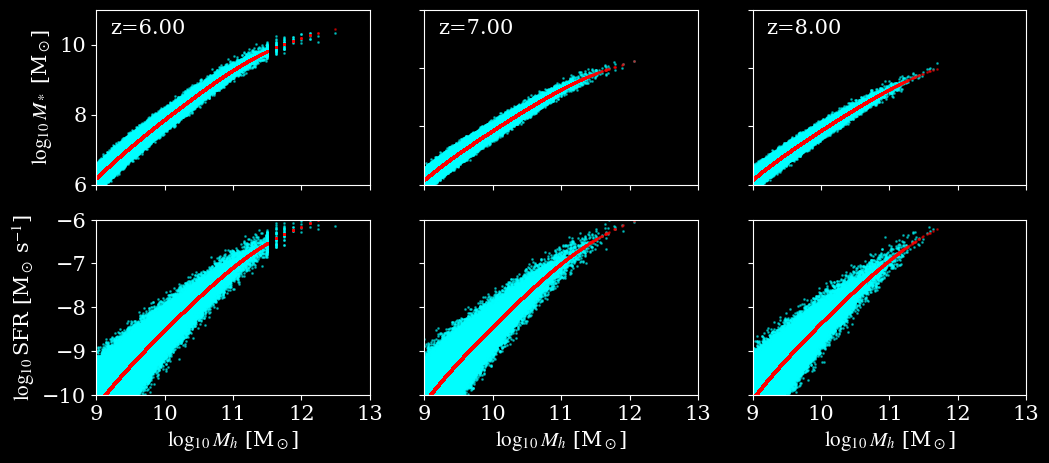

In [106]:
# visualize stochasticity in each relationship
fig, axs = plt.subplots(2, 3, figsize=(12, 5), sharex=True)

for i in range(3):
    axs[0,i].plot(np.log10(halo_masses_list[i]), np.log10(stellar_masses_stoch[i]), 'o', color='cyan', markersize=1, alpha=0.5)
    axs[0,i].plot(np.log10(halo_masses_list[i]), np.log10(stellar_masses_no_stoch[i]), 'o', color='red', markersize=1, alpha=0.5)

    axs[0,i].text(0.05, 0.95, f'z={inputs.node_redshifts[::-1][i]:.2f}', ha='left', va='top', transform=axs[0,i].transAxes, fontsize=label_size)

    axs[1,i].plot(np.log10(halo_masses_list[i]), np.log10(sfr_stoch[i]), 'o', color='cyan', markersize=1, alpha=0.5)
    axs[1,i].plot(np.log10(halo_masses_list[i]), np.log10(sfr_no_stoch[i]), 'o', color='red', markersize=1, alpha=0.5)
    axs[1,i].set_xlabel(r'$\log_{10} M_h$ [M$_\odot$]', fontsize=label_size)

    axs[0,i].set_xlim(9, 13)
    axs[0,i].set_ylim(6, 11)
    axs[1,i].set_ylim(-10, -6)

axs[0,1].set_yticks(axs[0,0].yaxis.get_majorticklocs())
axs[0,1].set_yticklabels([])
axs[0,2].set_yticks(axs[0,0].yaxis.get_majorticklocs())
axs[0,2].set_yticklabels([])
axs[1,1].set_yticks(axs[1,0].yaxis.get_majorticklocs())
axs[1,1].set_yticklabels([])
axs[1,2].set_yticks(axs[1,0].yaxis.get_majorticklocs())
axs[1,2].set_yticklabels([])

axs[0,0].set_ylabel(r'$\log_{10} M_*$ [M$_\odot$]', fontsize=label_size)
axs[1,0].set_ylabel(r'$\log_{10}$SFR [M$_\odot$ s$^{-1}$]', fontsize=label_size)

plt.show()

Not bad! But this doesn't tell us much. Now I'll write in some reference data below: the UV luminosity function measured by Bouwens et al. (2021) https://arxiv.org/abs/2102.07775 using the Hubble Space Telescope.

In [93]:
# BOUWENS 2021
b21_mag = [[-22.52, -22.02, -21.52, -21.02, -20.52, -20.02, -19.52, -18.77, -17.77, -16.77],
          [-22.19, -21.69, -21.19, -20.68, -20.19, -19.69, -19.19, -18.69, -17.94, -16.94],
          [-21.85, -21.35, -20.85, -20.10, -19.35, -18.6, -17.6]]
b21_phi = [[2e-6, 1.4e-5, 5.1e-5, 1.69e-4, 3.17e-4, 7.24e-4, 1.124e-3, 2.82e-3, 8.36e-3, 1.71e-2],
          [1e-6, 4.1e-5, 4.7e-5, 1.98e-4, 2.83e-4, 5.89e-4, 1.172e-3, 1.433e-3, 5.76e-3, 8.32e-3],
          [3e-6, 1.2e-5, 4.1e-5, 1.2e-4, 6.57e-4, 1.1e-3, 3.02e-3]]
b21_phi_err = [[2e-6, 5e-6, 1.1e-5, 2.4e-5, 4.1e-5, 8.7e-5, 1.57e-4, 4.4e-4, 1.66e-3, 5.26e-3],
              [2e-6, 1.1e-5, 1.5e-5, 3.6e-5, 6.6e-5, 1.26e-4, 3.36e-4, 4.19e-4, 1.44e-3, 2.9e-3],
              [2e-6, 4e-6, 1.1e-5, 4e-5, 2.33e-4, 3.4e-4, 1.14e-3]]

b21_6 = np.array(b21_phi[0])
b21_7 = np.array(b21_phi[1])
b21_8 = np.array(b21_phi[2])

b21_6_err = np.array(b21_phi_err[0])
b21_7_err = np.array(b21_phi_err[1])
b21_8_err = np.array(b21_phi_err[2])

logphi_b21_6 = np.log10(b21_6)
logphi_b21_7 = np.log10(b21_7)
logphi_b21_8 = np.log10(b21_8)

logphi_err_b21_6_up = np.log10(b21_6 + b21_6_err) - logphi_b21_6
logphi_err_b21_7_up = np.log10(b21_7 + b21_7_err) - logphi_b21_7
logphi_err_b21_8_up = np.log10(b21_8 + b21_8_err) - logphi_b21_8

logphi_err_b21_6_low = logphi_b21_6 - np.log10(b21_6 - b21_6_err)
logphi_err_b21_7_low = logphi_b21_7 - np.log10(b21_7 - b21_7_err)
logphi_err_b21_8_low = logphi_b21_8 - np.log10(b21_8 - b21_8_err)

logphi_err_b21_6_low[np.isinf(logphi_err_b21_6_low)] = np.abs(logphi_b21_6[np.isinf(logphi_err_b21_6_low)])
logphi_err_b21_7_low[np.isinf(logphi_err_b21_7_low)] = np.abs(logphi_b21_7[np.isinf(logphi_err_b21_7_low)])
logphi_err_b21_8_low[np.isinf(logphi_err_b21_8_low)] = np.abs(logphi_b21_8[np.isinf(logphi_err_b21_8_low)])

logphi_err_b21_6_low[np.isnan(logphi_err_b21_6_low)] = np.abs(logphi_b21_6[np.isnan(logphi_err_b21_6_low)])
logphi_err_b21_7_low[np.isnan(logphi_err_b21_7_low)] = np.abs(logphi_b21_7[np.isnan(logphi_err_b21_7_low)])
logphi_err_b21_8_low[np.isnan(logphi_err_b21_8_low)] = np.abs(logphi_b21_8[np.isnan(logphi_err_b21_8_low)])

asymmetric_error_6 = np.array(list(zip(logphi_err_b21_6_low, logphi_err_b21_6_up))).T
asymmetric_error_7 = np.array(list(zip(logphi_err_b21_7_low, logphi_err_b21_7_up))).T
asymmetric_error_8 = np.array(list(zip(logphi_err_b21_8_low, logphi_err_b21_8_up))).T

/tmp/ipykernel_141416/756378088.py:28: RuntimeWarning: divide by zero encountered in log10
  logphi_err_b21_6_low = logphi_b21_6 - np.log10(b21_6 - b21_6_err)
/tmp/ipykernel_141416/756378088.py:29: RuntimeWarning: invalid value encountered in log10
  logphi_err_b21_7_low = logphi_b21_7 - np.log10(b21_7 - b21_7_err)


For direct comparison, I must calculate the UV luminosities of the galaxies in my sample, and then bin them into the same bins measured by Bouwens et al.

We suppose that UV luminosity scales linearly with star formation rate (reasonable since the UV magnitude of a galaxy is dominated by type O and B stars, whose lifetimes are tens of million years).

\begin{equation}
    {\rm M}_{\rm UV}=51.64 - 2.5 \log_{10}\left(\frac{3.1557\cdot10^7 {\rm s}\:{\rm yr}^{-1}}{1.15\cdot10^{-28} {\rm M}_\odot\:{\rm erg}^{-1}\:{\rm yr}^{-1}\:{\rm s}\:{\rm Hz}}{\rm SFR}\right)
\end{equation}

In [94]:
def get_muv(sfr):
    kappa = 1.15e-28
    luv = sfr * 3.1557e7 / kappa
    muv = 51.64 - np.log10(luv) / 0.4
    return muv

In [95]:
muv_stoch_6 = get_muv(sfr_stoch[0])
muv_stoch_7 = get_muv(sfr_stoch[1])
muv_stoch_8 = get_muv(sfr_stoch[2])
muv_no_stoch_6 = get_muv(sfr_no_stoch[0])
muv_no_stoch_7 = get_muv(sfr_no_stoch[1])
muv_no_stoch_8 = get_muv(sfr_no_stoch[2])

In [96]:
def make_uvlf(muv, b21_mag_bins):
    bin_edges = []
    SIDE_LENGTH_MPC = inputs.simulation_options.BOX_LEN
    bin_centers = np.asarray(b21_mag_bins)
    bin_edge = np.zeros(len(bin_centers)+1)
    bin_widths = (bin_centers[1:] - bin_centers[:-1])*0.5
    bin_edge[0] = bin_centers[0]-bin_widths[0]
    bin_edge[-1] = bin_centers[-1] + bin_widths[-1]
    bin_edge[1:-1] = bin_widths + bin_centers[:-1]

    heights, bins = np.histogram(muv, bins=bin_edge)

    # print(heights, bins)

    bin_centers = 0.5*(bins[1:]+bins[:-1])
    bin_widths = bins[1:]-bins[:-1]
    uv_phi = heights/bin_widths/(SIDE_LENGTH_MPC**3)
    uv_phi_err = np.sqrt(heights)/bin_widths/(SIDE_LENGTH_MPC**3)

    # print(uv_phi)

    log_uv_phi_err_up = np.abs(np.log10(uv_phi_err+uv_phi) - np.log10(uv_phi))
    log_uv_phi_err_low = np.abs(np.log10(np.abs(uv_phi-uv_phi_err)) - np.log10(uv_phi))
    log_uv_phi_err_low[np.isinf(log_uv_phi_err_low)] = np.abs(np.log10(uv_phi[np.isinf(log_uv_phi_err_low)]))
    log_uv_asymmetric_error = np.array(list(zip(log_uv_phi_err_low, log_uv_phi_err_up))).T

    return uv_phi, log_uv_asymmetric_error

In [ ]:
uvlf6_stoch, uvlf6_stoch_err       = make_uvlf(muv_stoch_6, b21_mag[0])
uvlf6_no_stoch, uvlf6_no_stoch_err = make_uvlf(muv_no_stoch_6, b21_mag[0])
uvlf7_stoch, uvlf7_stoch_err       = make_uvlf(muv_stoch_7, b21_mag[1])
uvlf7_no_stoch, uvlf7_no_stoch_err = make_uvlf(muv_no_stoch_7, b21_mag[1])
uvlf8_stoch, uvlf8_stoch_err       = make_uvlf(muv_stoch_8, b21_mag[2])
uvlf8_no_stoch, uvlf8_no_stoch_err = make_uvlf(muv_no_stoch_8, b21_mag[2])

/tmp/ipykernel_141416/3761818454.py:22: RuntimeWarning: divide by zero encountered in log10
  log_uv_phi_err_up = np.abs(np.log10(uv_phi_err+uv_phi) - np.log10(uv_phi))
/tmp/ipykernel_141416/3761818454.py:22: RuntimeWarning: invalid value encountered in subtract
  log_uv_phi_err_up = np.abs(np.log10(uv_phi_err+uv_phi) - np.log10(uv_phi))
/tmp/ipykernel_141416/3761818454.py:23: RuntimeWarning: divide by zero encountered in log10
  log_uv_phi_err_low = np.abs(np.log10(np.abs(uv_phi-uv_phi_err)) - np.log10(uv_phi))
/tmp/ipykernel_141416/3761818454.py:23: RuntimeWarning: invalid value encountered in subtract
  log_uv_phi_err_low = np.abs(np.log10(np.abs(uv_phi-uv_phi_err)) - np.log10(uv_phi))


/tmp/ipykernel_141416/3485348234.py:2: RuntimeWarning: divide by zero encountered in log10
  axs.errorbar(b21_mag[0], np.log10(uvlf6_stoch), yerr=-1*np.log10(uvlf6_stoch)*uvlf6_stoch_err, fmt='o', color='cyan', \
/tmp/ipykernel_141416/3485348234.py:4: RuntimeWarning: divide by zero encountered in log10
  axs.errorbar(b21_mag[0], np.log10(uvlf6_no_stoch), yerr=-1*np.log10(uvlf6_no_stoch)*uvlf6_no_stoch_err, \


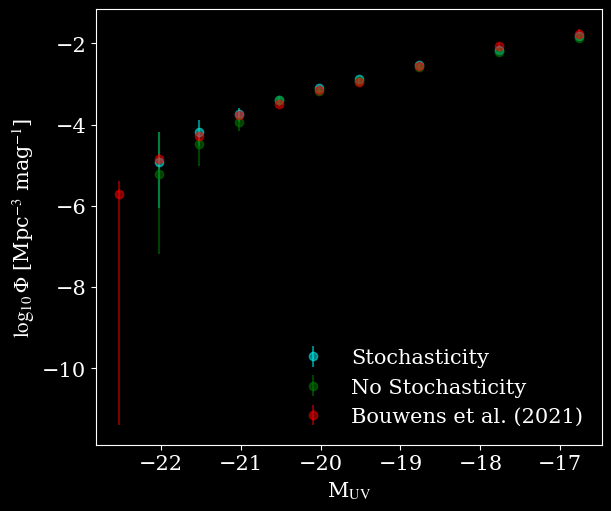

In [107]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)
axs.errorbar(b21_mag[0], np.log10(uvlf6_stoch), yerr=-1*np.log10(uvlf6_stoch)*uvlf6_stoch_err, fmt='o', color='cyan', \
             alpha=0.5, label='Stochasticity')
axs.errorbar(b21_mag[0], np.log10(uvlf6_no_stoch), yerr=-1*np.log10(uvlf6_no_stoch)*uvlf6_no_stoch_err, \
             fmt='o', color='green', alpha=0.5, label='No Stochasticity')
axs.errorbar(b21_mag[0], logphi_b21_6, yerr=asymmetric_error_6, fmt='o', color='red', alpha=0.5, label='Bouwens et al. (2021)')

axs.set_ylabel(r'$\log_{10} \Phi$ [Mpc$^{-3}$ mag$^{-1}$]', fontsize=label_size)
axs.set_xlabel(r'M$_{\rm UV}$', fontsize=label_size)
axs.legend(fontsize=label_size, loc='lower right', frameon=False)
plt.show()

The UVLF with and without stochasticity can fairly accurately fit the bright end of the UVLF measured by Bouwens et al (2021).